# Basic introduction


This notebook focuses on brain tumor detection, where we will apply Transfer Learning. We will use the the basic VGG model as an feature extractor. Then a Attention Layer will give the weight on these features to get ready for the FC to do the classification.

# About Dataset


The Dataset that we will use can be found at this site: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/data

The dataset contains 2 folders: yes and no  which contains 3060 Brain MRI Images.

# Import Libraries

In [1]:
import cv2
import os
import numpy as np
import pandas as pd
import seaborn as sns
import random
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle
import glob
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,Conv2D, Dense, Flatten ,Dropout ,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D,Multiply,Reshape
from tensorflow.keras import layers, Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping


from tensorflow.keras.applications import VGG16

from PIL import Image

import tensorflow as tf
from tensorflow import keras
import warnings
warnings.filterwarnings('ignore')

# Load Dataset



In [2]:
path_No = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/*'
path_Yes = '/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/*'

tumor = []
no_tumor = []
random_state = 42

for file in glob.iglob(path_Yes):
    img = cv2.imread(file)      #Reading the images from the path
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)        #Changing the color from BGR to RGB
    img = cv2.resize(img, (128, 128)) 
    tumor.append((img, 1))  # Appending tuple with image and label 1 (indicating presence of tumor)

for file in glob.iglob(path_No):
    img = cv2.imread(file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (128, 128))
    no_tumor.append((img, 0))  # Appending tuple with image and label 0 (indicating absence of tumor)

# Concatenating the two lists and shuffle the data
all_data = tumor + no_tumor


# Splitting data and labels
data = np.array([item[0] for item in all_data])
labels = np.array([item[1] for item in all_data])

# Exploratary  Data analysis (EDA)


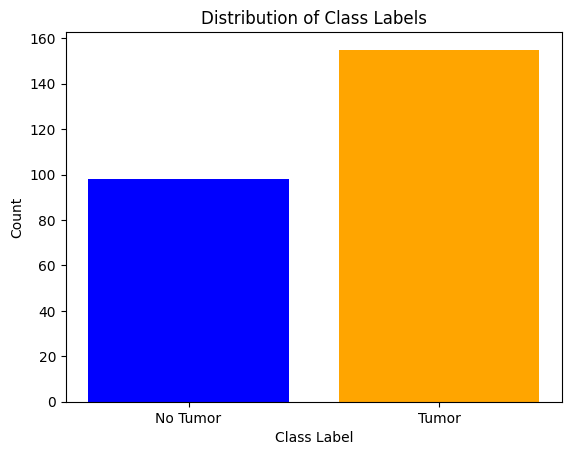

In [3]:
# Counting the occurrences of each class label
unique_labels, label_counts = np.unique(labels, return_counts=True)

plt.bar(unique_labels, label_counts, color=['blue', 'orange'])
plt.xticks(unique_labels, ['No Tumor', 'Tumor'])
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.title('Distribution of Class Labels')
plt.show()


# Data Scaling - Split

In [4]:
x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.20, random_state=42)

x_train= x_train /255.0
x_test = x_test / 255.0

print('Training size: ', x_train.shape)

Training size:  (202, 128, 128, 3)


# Build Model

In [5]:
# Pretrained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

# Squeeze-and-Excitation (SE) block example
def se_block(input_tensor, reduction_ratio=16):
    channel_axis = -1  # TensorFlow uses channels-last format
    filters = input_tensor.shape[channel_axis]
    se = GlobalAveragePooling2D()(input_tensor)
    se = Dense(filters // reduction_ratio, activation='relu')(se)
    se = Dense(filters, activation='sigmoid')(se)
    se = Reshape((1, 1, filters))(se)
    return Multiply()([input_tensor, se])

# Apply SE block after a feature map
x = base_model.output
x = se_block(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation = 'sigmoid')(x)

# Final model
model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Train Model

In [6]:
# Define callbacks function
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.99:
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True
            
back = myCallback()     

# Optional: EarlyStopping to stop training if no improvement
early_stopping = EarlyStopping(
    monitor='val_accuracy',   # Metric to monitor
    patience=20,               # Number of epochs with no improvement before stopping
    mode='max',               # 'max' for accuracy, 'min' for loss
    verbose=1
)

In [7]:
history = model.fit(x_train, 
                    y_train,
                    epochs=100,
                    batch_size=32,
                    validation_split=0.2,
                   callbacks=[back, early_stopping])

Epoch 1/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 17s 1s/step - accuracy: 0.6370 - loss: 0.6955 - val_accuracy: 0.6341 - val_loss: 0.6064
Epoch 2/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7227 - loss: 0.5698 - val_accuracy: 0.7805 - val_loss: 0.5511
Epoch 3/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7298 - loss: 0.5535 - val_accuracy: 0.6829 - val_loss: 0.5407
Epoch 4/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7317 - loss: 0.5345 - val_accuracy: 0.6341 - val_loss: 0.5973
Epoch 5/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8108 - loss: 0.4603 - val_accuracy: 0.8049 - val_loss: 0.4777
Epoch 6/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8166 - loss: 0.4216 - val_accuracy: 0.8293 - val_loss: 0.4773
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7807 - loss: 0.4351 - val_accuracy: 0.7805 - val_loss: 0.4875
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.7728 - loss: 0.4606 - val_accuracy: 0.8049 - val_loss: 

# Results

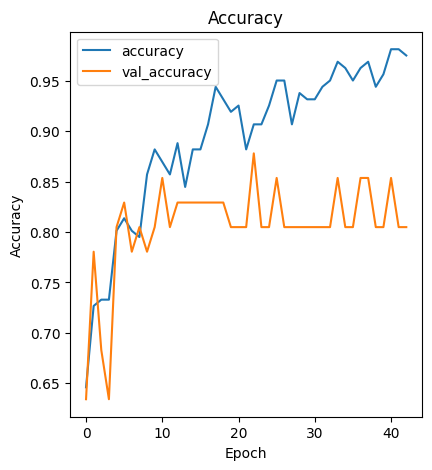

In [8]:
# plot the accuracy and loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

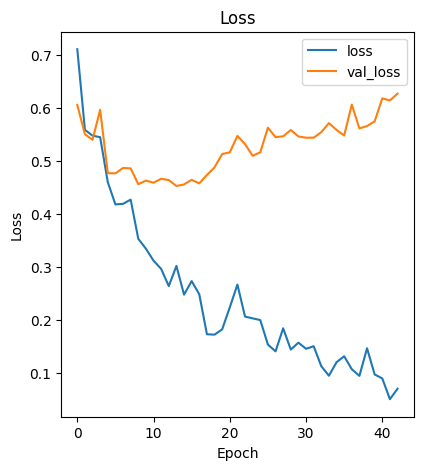

In [9]:
# model loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")
plt.show()


In [10]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_acc)

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - accuracy: 0.9034 - loss: 0.4469 
Test Loss: 0.4525747001171112
Test Accuracy: 0.9019607901573181


In [11]:
# Assuming 'model' is your trained Keras model
model.save("brain_tumor.h5")